## Assignment for Week 4 - Decision Trees and Random Forest

### Exercise:
German credit dataset: located in the assign_wk4 folder

**Objective:** to minimize loss from the bank’s perspective.

Bank (by loan manager) needs to decide who will get loan approval based on the applicants’ demographic and socio-economic profiles. The data set consists of 20 variables and classification on applicant whether he/she has good or bad credit risk. The predictive model will provide guidance in making loan approval decision on prospective applicants based on clients’ profiles.

From the given data set, perform the task using decision tree. 
* What are your findings?
* Plot and interpret the tree.
* Prune the tree from the previous result. 
   - Does the pruned tree show any performance improvement?  
   - What attributes are found in the pruned tree?  
* Conclude your finding.

From the given data set, perform the task using random forest. 
* Summarize your finding.

Compare results of decision tree and random forest.

### Deliverables:

Upload your notebook's .ipynb file.
   
**Important:** Make sure your provide complete and thorough explanations for all of your analysis. You need to defend your thought processes and reasoning.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import seaborn as sns 

In [2]:
# !pip install graphviz
# !pip install dtreeviz

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/Regis MSDS Notebooks/Machine Learning/Week 4/assign_wk4/german_credit_risk.csv'
data = pd.read_csv(path, encoding='utf-8')

# EDA

In [5]:
def summary(dataframe):
    null_counts = dataframe.isna().sum()
    preview = print(
        "Example Data:\n"
        f"{json.dumps(dataframe.head(1).to_dict('records'), indent=2)}\n"
        "Data Info:\n"
        f"{dataframe.info()}\n"
        "Missing Values:\n"
        f"{null_counts}"
    )

    return preview
summary(data)         
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Checking.Account   1000 non-null   object
 1   Duration           1000 non-null   int64 
 2   Credit.Hist        1000 non-null   object
 3   Purpose            1000 non-null   object
 4   Credit.Amount      1000 non-null   int64 
 5   Saving.Account     1000 non-null   object
 6   Employmnet         1000 non-null   object
 7   Disposable.Income  1000 non-null   int64 
 8   Personal.Status    1000 non-null   object
 9   Other.Debtors      1000 non-null   object
 10  Present.Residence  1000 non-null   int64 
 11  Property           1000 non-null   object
 12  Age                1000 non-null   int64 
 13  Other.Loans        1000 non-null   object
 14  Housing            1000 non-null   object
 15  Existing.Credits   1000 non-null   int64 
 16  Job                1000 non-null   object
 

Checking.Account  Duration Credit.Hist Purpose  Credit.Amount  \
0              A11         6         A34     A43           1169   
1              A12        48         A32     A43           5951   
2              A14        12         A34     A46           2096   
3              A11        42         A32     A42           7882   
4              A11        24         A33     A40           4870   

  Saving.Account Employmnet  Disposable.Income Personal.Status Other.Debtors  \
0            A65        A75                  4             A93          A101   
1            A61        A73                  2             A92          A101   
2            A61        A74                  2             A93          A101   
3            A61        A74                  2             A93          A103   
4            A61        A73                  3             A93          A101   

   ...  Property Age  Other.Loans Housing Existing.Credits   Job  \
0  ...      A121  67         A143    A152                2  A173   
1  ...      A121  22         A143    A152                1  A173   
2  ...      A121  49         A143    A152                1  A172   
3  ...      A122  45         A143    A153                1  A173   
4  ...      A124  53         A143    A153                2  A173   

  Number.Liable  Telephone Foreign.Worker Cost.Matrix  
0             1       A192           A201           1  
1             1       A191           A201           2  
2             2       A191           A201           1  
3             2       A191           A201           1  
4             2       A191           A201           2  

[5 rows x 21 columns]

Based upon the summary of the data, there are not any missing values, mostly string objects and integers for types, and a dimension of 21 columns. Let's get a better idea of the correlations present with the target variable with a couple of views: 

- Grouped averages of each feature based upon the predicted output
- Correlations in the dataset


 				 AVERAGE METRICS BY THE TARGET VARIABLE 



Cost.Matrix   Duration  Credit.Amount  Disposable.Income  \
0            1  19.207143    2985.457143           2.920000   
1            2  24.860000    3938.126667           3.096667   

   Present.Residence        Age  Existing.Credits  Number.Liable  
0           2.842857  36.224286          1.424286       1.155714  
1           2.850000  33.963333          1.366667       1.153333

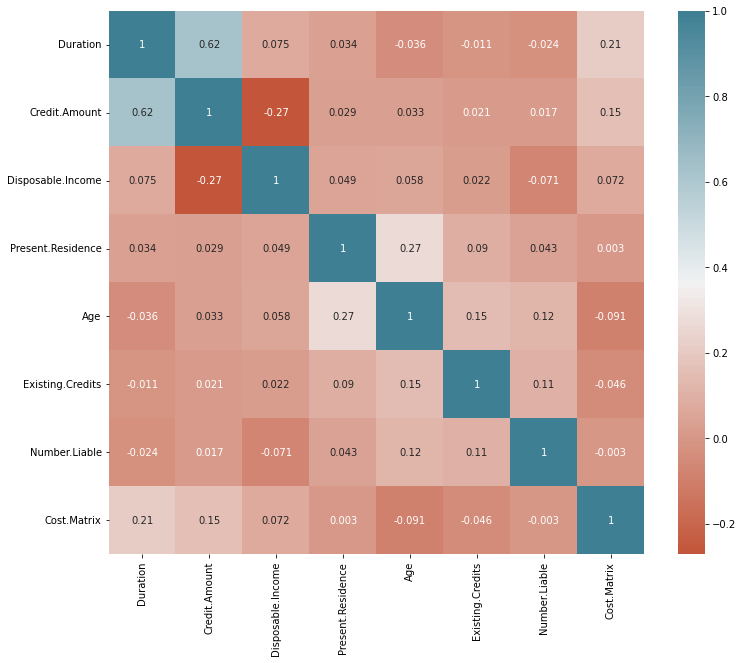

In [6]:
# TARGET VARIABLE SUBSET
print('\n \t\t\t\t AVERAGE METRICS BY THE TARGET VARIABLE \n')
target = data.groupby('Cost.Matrix').mean().reset_index()

# CORRELATION MATRIX 
corrs = data.corr()

fig = plt.figure(figsize=(12,10))
sns.heatmap(corrs, annot=True, cmap=sns.diverging_palette(20, 220, n=200))

target

Based upon the above illustrations, I infer that the riskiest applicants have more credit. The correlations are strongest with credit amount and duration of lines of credit in terms of positive correlations. For negative correlations, the younger of the applicants tend to be higher risk, but not by much. Other negative correlations are near zero and don't pose a significant value. 

Prior to running the algorithm, it helps to also understand the balance or distribution of the target variable, Cost Matrix:

Text(0.5, 0, 'Cost Matrix')

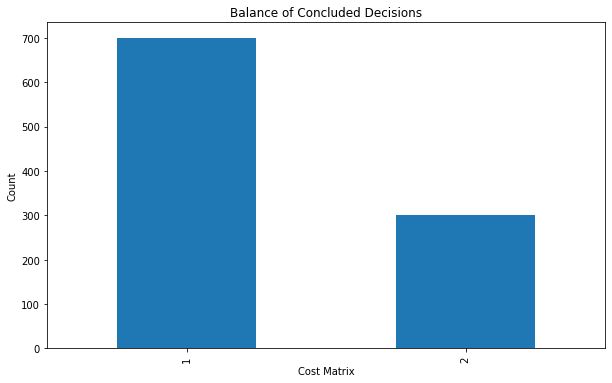

In [7]:
target_vals = data['Cost.Matrix'].value_counts()

figure = plt.figure(figsize=(10,6))
target_vals.plot(kind='bar')
plt.title('Balance of Concluded Decisions')
plt.ylabel('Count')
plt.xlabel('Cost Matrix')

Assuming that `Cost.Matrix` is the target variable for classification, taking a look at it appears to show the values of 1 or 2. To avoid confusion, I will be referring to the names file that describes this dataset to map these values to corresponding positive and negative outcomes based upon the following summary of the target variable, `Cost.Matrix`: 

8.  Cost Matrix

This dataset requires use of a cost matrix (see below)


| _  | 1 | 2 |
|---|---|---|
| 1 | 0 | 1 |
| 2 | 5 | 0 |

(1 = Good,  2 = Bad)

the rows represent the actual classification and the columns
the predicted classification.

It is worse to class a customer as good when they are bad (5), 
than it is to class a customer as bad when they are good (1).

#### New Definition:
If classified as good, label 0. If classified as bad or high risk, label 1.


In [8]:
data['Cost.Matrix'] = data['Cost.Matrix'].apply(lambda x: 1 if x == 2 else 0)
new_target_vals = data['Cost.Matrix'].value_counts()

In [9]:
print(
    f"Previous Target Variable:\n{target_vals}\n"
    "__________________________________________\n"
    f"New Target Values:\n{new_target_vals}"
)

Previous Target Variable:
1    700
2    300
Name: Cost.Matrix, dtype: int64
__________________________________________
New Target Values:
0    700
1    300
Name: Cost.Matrix, dtype: int64


### Encoding Categorical Variables

Given there are many objects, we can categorize them and this will enable the model to better determine its decisions. 

In [10]:
categorical_transform = pd.DataFrame({
    k: data[f'{k}'].astype('category') if k in data.select_dtypes(include='object') else data[f'{k}']
    for k in data 
})
summary(categorical_transform)
categorical_transform.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Checking.Account   1000 non-null   category
 1   Duration           1000 non-null   int64   
 2   Credit.Hist        1000 non-null   category
 3   Purpose            1000 non-null   category
 4   Credit.Amount      1000 non-null   int64   
 5   Saving.Account     1000 non-null   category
 6   Employmnet         1000 non-null   category
 7   Disposable.Income  1000 non-null   int64   
 8   Personal.Status    1000 non-null   category
 9   Other.Debtors      1000 non-null   category
 10  Present.Residence  1000 non-null   int64   
 11  Property           1000 non-null   category
 12  Age                1000 non-null   int64   
 13  Other.Loans        1000 non-null   category
 14  Housing            1000 non-null   category
 15  Existing.Credits   1000 non-null   int64   
 16  Job    

Checking.Account  Duration Credit.Hist Purpose  Credit.Amount  \
0              A11         6         A34     A43           1169   
1              A12        48         A32     A43           5951   
2              A14        12         A34     A46           2096   
3              A11        42         A32     A42           7882   
4              A11        24         A33     A40           4870   

  Saving.Account Employmnet  Disposable.Income Personal.Status Other.Debtors  \
0            A65        A75                  4             A93          A101   
1            A61        A73                  2             A92          A101   
2            A61        A74                  2             A93          A101   
3            A61        A74                  2             A93          A103   
4            A61        A73                  3             A93          A101   

   ...  Property Age  Other.Loans Housing Existing.Credits   Job  \
0  ...      A121  67         A143    A152                2  A173   
1  ...      A121  22         A143    A152                1  A173   
2  ...      A121  49         A143    A152                1  A172   
3  ...      A122  45         A143    A153                1  A173   
4  ...      A124  53         A143    A153                2  A173   

  Number.Liable  Telephone Foreign.Worker Cost.Matrix  
0             1       A192           A201           0  
1             1       A191           A201           1  
2             2       A191           A201           0  
3             2       A191           A201           0  
4             2       A191           A201           1  

[5 rows x 21 columns]

In [11]:
def category_encoder(data):
    categories = data.select_dtypes(include='category')
    for col in categories.columns: 
        data[f'{col}'] = data[f'{col}'].cat.codes
    return data

final_df = category_encoder(categorical_transform)
final_df.head()

Checking.Account  Duration  Credit.Hist  Purpose  Credit.Amount  \
0                 0         6            4        4           1169   
1                 1        48            2        4           5951   
2                 3        12            4        7           2096   
3                 0        42            2        3           7882   
4                 0        24            3        0           4870   

   Saving.Account  Employmnet  Disposable.Income  Personal.Status  \
0               4           4                  4                2   
1               0           2                  2                1   
2               0           3                  2                2   
3               0           3                  2                2   
4               0           2                  3                2   

   Other.Debtors  ...  Property  Age  Other.Loans  Housing  Existing.Credits  \
0              0  ...         0   67            2        1                 2   
1              0  ...         0   22            2        1                 1   
2              0  ...         0   49            2        1                 1   
3              2  ...         1   45            2        2                 1   
4              0  ...         3   53            2        2                 2   

   Job  Number.Liable  Telephone  Foreign.Worker  Cost.Matrix  
0    2              1          1               0            0  
1    2              1          0               0            1  
2    1              2          0               0            0  
3    2              2          0               0            0  
4    2              2          0               0            1  

[5 rows x 21 columns]

# Decision Tree

Performing the decision tree can be visited directly, knowing the following: 

- There are no missing values
- The target variable has been defined to a binary value for simple binary classification on the leaf level. 
- There are now categories to act as edge nodes for the binary search within the decision trees for this algorithm

In [12]:
cols = final_df.columns
prediction_col = final_df['Cost.Matrix']
feature_cols = final_df.loc[:, cols != 'Cost.Matrix']

x = feature_cols.values
y = prediction_col.values

#split the dataset into the train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

In [13]:
# establish and fit the model using DecisonTree()
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(x_train, y_train)

#gathering the predictions
preds = tree_model.predict(x_test)
preds

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [14]:
#display the actuals and predictions for the test set
print('Actuals for test data set')
print(pd.value_counts(y_test))
print('Predictions for test data set')
print(pd.value_counts(preds))

Actuals for test data set
0    209
1     91
dtype: int64
Predictions for test data set
0    222
1     78
dtype: int64


Text(0.5, 1.0, 'Actual Values')

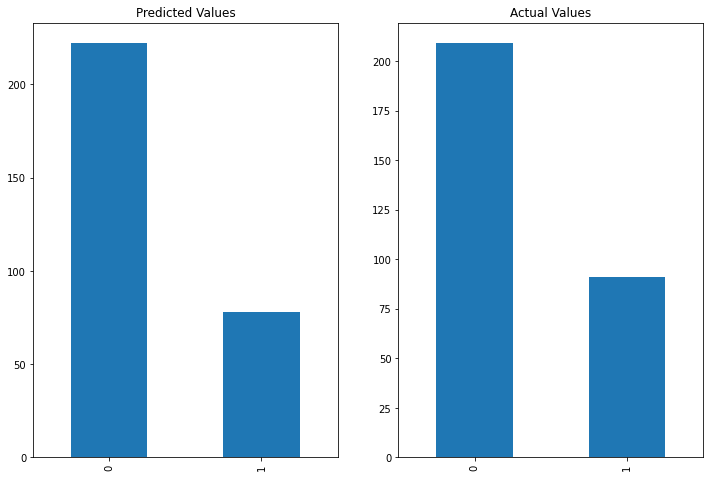

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)

predicted_vals=pd.value_counts(preds, sort= True)
actual_vals=pd.value_counts(y_test, sort= True)

predicted_vals.plot(kind= 'bar')
plt.title('Predicted Values')

plt.subplot(1, 2, 2)

actual_vals.plot(kind= 'bar')
plt.title('Actual Values')


Now, I can evaluate the accuracy and plot the tree. 

In [16]:
print(accuracy_score(y_test,preds))

0.6766666666666666


With an accuracy of ~70%, the model falsely predicted the risk of targets and assumed lower risk. For visibility into this, we can plot the confusion matrix

In [ ]:
cm = confusion_matrix(y_test, preds)
target_labels = np.unique(y_test)

plt.figure(figsize=(10,10))

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Blues",
            xticklabels=target_labels, yticklabels=target_labels)
plt.title('Confusion Matrix')
plt.xlabel('predicted label')
plt.ylabel('actual label')
plt.show()

## Visualize the Tree

In [18]:
# Method 1: sklearn.tree plot_tree attribute
# fig = plt.figure(figsize=(25,20))
# tree_model.plot_tree(tree_model, feature_names=feature_cols.columns, class_names=prediction_col, filled=True)

In [19]:
# Method 2: dtreeviz library
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(
    tree_model, x, y,
    target_name="target",
    feature_names=feature_cols.columns,
    class_names=list(prediction_col.values)
)

viz

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


## Pruning 

Using the `criterion` attribute for either Gini impurity or cross-entropy, `splitter` for controlling the split path for decisions on leaf nodes, and a built-in feature of the Decision Tree, `max-depth`, we can limit the range of the decision tree to prevent underfitting or overfitting. 

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.cost_complexity_pruning_path

https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

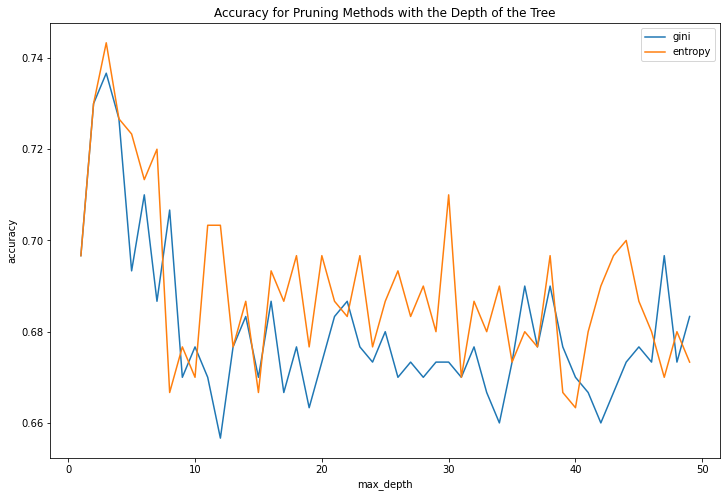

In [20]:
max_depth, acc_gini, acc_entropy = [], [], []

for i in range(1, 50):
    
 new_tree = tree.DecisionTreeClassifier(criterion="gini", max_depth=i)
 new_tree.fit(x_train, y_train)
 new_pred = new_tree.predict(x_test)

 acc_gini.append(accuracy_score(y_test, new_pred))
    
 ####
 new_tree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=i)
 new_tree.fit(x_train, y_train)
 pred = new_tree.predict(x_test)
 acc_entropy.append(accuracy_score(y_test, pred))
 ####
    
 max_depth.append(i)


d = pd.DataFrame({
    "acc_gini":pd.Series(acc_gini), 
    "acc_entropy":pd.Series(acc_entropy),
    "max_depth":pd.Series(max_depth)
})
# visualizing changes in parameters
fig = plt.figure(figsize=(12,8))
plt.title('Accuracy for Pruning Methods with the Depth of the Tree')
plt.plot("max_depth", "acc_gini", data=d, label="gini")
plt.plot("max_depth", "acc_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

The consistency of the tree is seen to be attributed more toward the entropy choice. Choosing entropy will increase accuracy and find a good balance without over-fitting. I'll visualize the tree after the fact, with about 25 leaf nodes given the accuracy appears most stable for entropy.

In [21]:
new_tree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10)
new_tree.fit(x_train, y_train)
new_pred = new_tree.predict(x_test)
pruned_tree = dtreeviz(
    new_tree, x, y, target_name="risk",
    feature_names=feature_cols.columns, class_names=list(prediction_col.values)
)

pruned_tree

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


The assessed risk was decided among Credit Amount and Employment by majority, which is an interesting observation when viewing the edge or leaf nodes at the very bottom of the tree. 

# Random Forest

Revisiting this process, I'll use a Random Forest and compare the results.

In [22]:
# establish and fit the model using RandomForestClassifier()
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

#gathering the predictions
rf_preds = rf_model.predict(x_test)
rf_preds

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0])

In [23]:
#display the actuals and predictions for the test set
print('Actuals for test data set')
print(pd.value_counts(y_test))
print('Predictions for test data set')
print(pd.value_counts(rf_preds))

Actuals for test data set
0    209
1     91
dtype: int64
Predictions for test data set
0    245
1     55
dtype: int64


Text(0.5, 1.0, 'Actual Values')

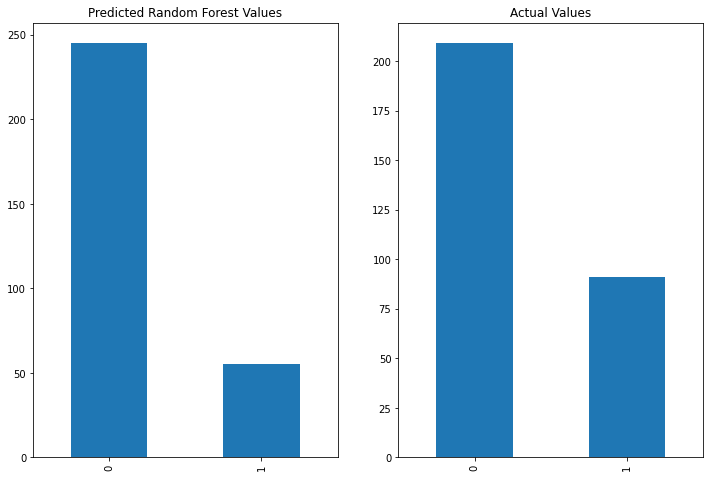

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)

predicted_vals=pd.value_counts(rf_preds, sort= True)
actual_vals=pd.value_counts(y_test, sort= True)

predicted_vals.plot(kind= 'bar')
plt.title('Predicted Random Forest Values')

plt.subplot(1, 2, 2)

actual_vals.plot(kind= 'bar')
plt.title('Actual Values')


Now, I can evaluate the accuracy and plot the tree. 

In [25]:
print(accuracy_score(y_test, rf_preds))

0.7666666666666667


With an accuracy of ~78%, the random forest performs significantly better. However, it appears to have  falsely predicted the risk of targets and assumed lower risk much like the decision tree. For visibility into this, we can plot the confusion matrix

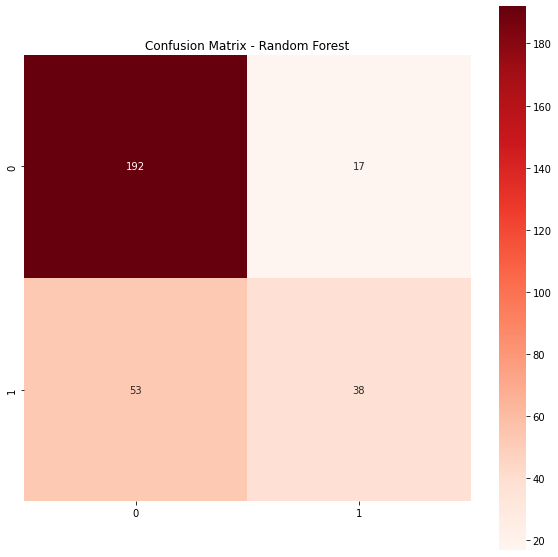

In [47]:
cm = confusion_matrix(y_test, rf_preds)
target_labels = np.unique(y_test)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('predicted label')
plt.ylabel('actual label');

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds",
            xticklabels=target_labels, yticklabels=target_labels)
plt.show()

While not as optimal as would be guessed, the random forest performs in a modest pattern. The false negatives, or falsely assumed risk of good applicants, is at a lower level than the decision tree predicted. The inverse of poor applicants falsely assumed lower risk is only slightly lower. The model is, at its best, required to correctly assume risk and vice versa. In total, the random forest on its own is measurably better.

## Visualize the Random Forest

The full random forest is a collection of trees, which would be determined by the number of estimators as trees, so for the purpose of readability I wasn't able to display the full forest. Please let me know if there's a more simple and clean way of displaying this :)

In [27]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(
    rf_model.estimators_, out_file='rf.dot', 
    feature_names = feature_cols.columns,
    class_names = list(prediction_col.values),
    rounded = True, proportion = False, 
    precision = 2, filled = True
)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'rf.png')

TypeError: ignored

## Pruning 

The concept of pruning applies mostly toward decision trees, as I've read that the bootstrapping effect of a random forest iterates so deeply into the data that it tends to mitigate the noise or dimensionality, thereby eliminating most of the bias that can be used to form decisions on leaf nodes. 

However, an alternative will be to increase or decrease the amount of trees to prevent over-fitting, and potentially eliminate multicollinearity as this may have a strength among the data which will last through bootstrapping: 

https://stats.stackexchange.com/questions/36298/why-is-pruning-not-needed-for-random-forest-trees

https://stats.stackexchange.com/questions/443548/random-forest-pruning-vs-stopping-criteria

For the sake of this exercise, I can apply entropy and the same amount of depth for each tree as used in the decision tree classifier

In [36]:
rf2_model = RandomForestClassifier(max_depth=10, criterion='entropy', random_state=0)  # choosing 100 trees by default of scikitlearn, entropy, and max_depth of 2.
rf2_model.fit(x_train, y_train)

#gathering the predictions
rf2_preds = rf2_model.predict(x_test)
rf2_preds

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [37]:
print(accuracy_score(y_test, rf2_preds))

0.7666666666666667


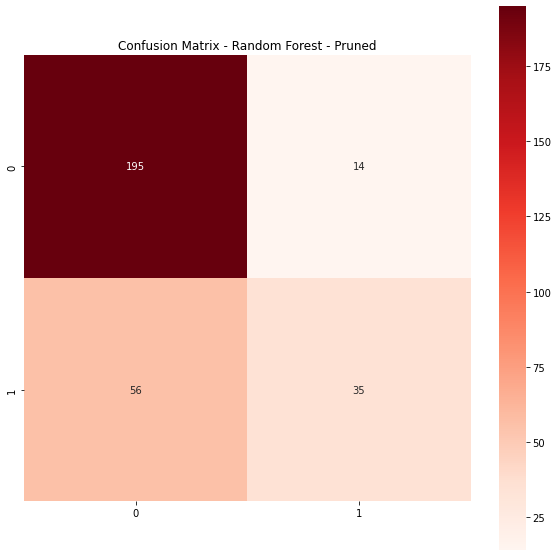

In [45]:
cm = confusion_matrix(y_test, rf2_preds)
target_labels = np.unique(y_test)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix - Random Forest - Pruned')
plt.xlabel('predicted label')
plt.ylabel('actual label');

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds",
            xticklabels=target_labels, yticklabels=target_labels)

plt.show()

# Conclusion

The random forest didn't perform much better with pruning as opposed to it being used with full trees. Overall, random forest is much more powerful on its own than individual trees and the assessment of it as a model for classification is that it would be very versatile, easily implemented, and resilient